## Spectrogram embeddings training
Adopted from Image similarity estimation using a Siamese Network with a contrastive loss at https://keras.io/examples/vision/siamese_contrastive/



### Setup

In [ ]:
!pip install -q datasets

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Hyperparameters

In [ ]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

### Make positive and negative pairs

In [ ]:
from random import choice, randint, sample
from tqdm import tqdm

def make_pairs(ds, num_pairs_per_track):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        ds: a dataset of a specific structure
            - for 80 different labels
            - 20 augmented samples per label
        num_pairs_per_track: number of pairs to create for each track

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    num_tracks = 80
    num_samples_per_track = 20

    pairs = []
    labels = []

    for track_idx in tqdm(range(num_tracks)):
        for pair_idx in range(num_pairs_per_track):

            # add a matching example
            # a random pair, both with the current label (track_id)
            pair_idxs = [track_idx*num_samples_per_track + index for index in sample(range(0, num_samples_per_track-1), 2)]

            x1 = ds[pair_idxs[0]]['image'].numpy()
            x2 = ds[pair_idxs[1]]['image'].numpy()

            pairs += [[x1, x2]]
            labels += [0]

            # add a non-matching example
            # a random sample with current label vs. random sample with _another_ label
            idx1 = track_idx*num_samples_per_track + randint(0, num_samples_per_track-1)
            random_track = choice([i for i in range(num_tracks) if i != track_idx])
            idx2 = random_track*num_samples_per_track + randint(0, num_samples_per_track-1)

            x1 = ds[idx1]['image'].numpy()
            x2 = ds[idx2]['image'].numpy()

            pairs += [[x1, x2]]
            labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [ ]:
%%time
# make pairs
pairs_train, labels_train = make_pairs( ds_train, 40)
pairs_val, labels_val = make_pairs( ds_train, 4)

100%|██████████| 80/80 [00:03<00:00, 23.13it/s]

CPU times: user 36.7 s, sys: 2.17 s, total: 38.9 s
Wall time: 38.2 s


In [ ]:
pairs_train.shape

(1600, 2, 224, 298, 3)

Split the training pairs

In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]
del pairs_train

In [ ]:
x_train_1.shape

(6400, 224, 298, 3)

Split the validation pairs

In [ ]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]
del pairs_val

### Define model

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
#define image dimensions
rows = 224
cols = 224

num_classes = 80

In [ ]:
#import VGG19
#from keras.applications import VGG19
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

#creating an object of vgg19 model and discarding the top layer
model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(rows, cols, 3))

# following https://keras.io/guides/transfer_learning/
model_vgg19.trainable = False

#model_vgg19.summary()

In [ ]:
embedding_dim = 1024

input = layers.Input((224, 298, 3))

# Input and preprocessing
x = layers.RandomCrop(rows, cols)(input)
x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(x)

# VGG19 core
x = model_vgg19(x)

# Postprocessing
x = layers.Flatten()(x)
#x = layers.Dense(2048, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(2048, activation='relu')(x)

# Embedding
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(embedding_dim, activation="tanh")(x)

embedding_network = keras.Model(input, x)

In [ ]:
input_1 = layers.Input((224, 298, 3))
input_2 = layers.Input((224, 298, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


### Define contrastive Loss

In [ ]:

def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


### Compile the model with the contrastive loss

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 298, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 224, 298, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 1024)                 4581587   ['input_3[0][0]',             
                                                          2          'input_4[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

## Train the model

100%|██████████| 80/80 [00:03<00:00, 22.55it/s]


Epoch 1/10
400/400 [==============================] - 78s 195ms/step - loss: 0.2522 - accuracy: 0.5044 - val_loss: 0.2518 - val_accuracy: 0.5125
Epoch 2/10
400/400 [==============================] - 77s 194ms/step - loss: 0.2502 - accuracy: 0.5131 - val_loss: 0.2510 - val_accuracy: 0.5078
Epoch 3/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2500 - accuracy: 0.5128 - val_loss: 0.2508 - val_accuracy: 0.5078
Epoch 4/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2497 - accuracy: 0.5175 - val_loss: 0.2507 - val_accuracy: 0.5078
Epoch 5/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2493 - accuracy: 0.5206 - val_loss: 0.2508 - val_accuracy: 0.5094
Epoch 6/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2494 - accuracy: 0.5252 - val_loss: 0.2509 - val_accuracy: 0.5078
Epoch 7/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2493 - accuracy: 0.5320 - val_loss: 0.2510 - val_ac

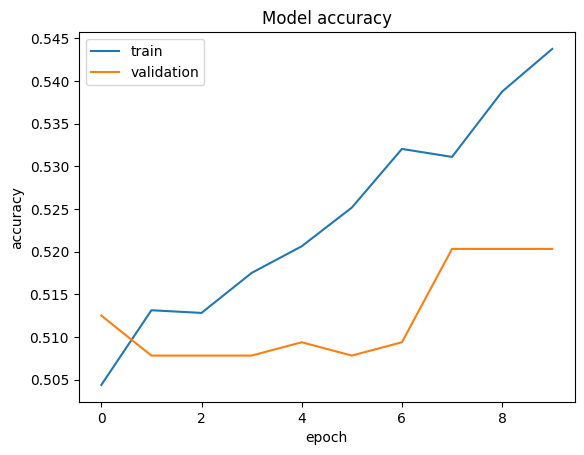

100%|██████████| 80/80 [00:03<00:00, 22.53it/s]


Epoch 1/10
400/400 [==============================] - 78s 195ms/step - loss: 0.2526 - accuracy: 0.4566 - val_loss: 0.2514 - val_accuracy: 0.4344
Epoch 2/10
400/400 [==============================] - 77s 194ms/step - loss: 0.2503 - accuracy: 0.4759 - val_loss: 0.2501 - val_accuracy: 0.4531
Epoch 3/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2500 - accuracy: 0.5028 - val_loss: 0.2497 - val_accuracy: 0.5328
Epoch 4/10
400/400 [==============================] - 78s 194ms/step - loss: 0.2497 - accuracy: 0.5191 - val_loss: 0.2487 - val_accuracy: 0.5484
Epoch 5/10
400/400 [==============================] - 77s 192ms/step - loss: 0.2482 - accuracy: 0.5422 - val_loss: 0.2423 - val_accuracy: 0.6281
Epoch 6/10
400/400 [==============================] - 77s 193ms/step - loss: 0.2159 - accuracy: 0.7523 - val_loss: 0.1656 - val_accuracy: 0.8813
Epoch 7/10
400/400 [==============================] - 77s 193ms/step - loss: 0.1377 - accuracy: 0.8983 - val_loss: 0.0810 - val_ac

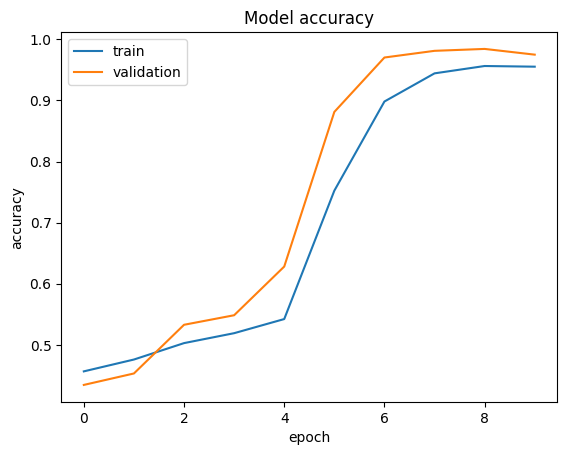

100%|██████████| 80/80 [00:03<00:00, 23.26it/s]


Epoch 1/10
400/400 [==============================] - 78s 195ms/step - loss: 0.0735 - accuracy: 0.9002 - val_loss: 0.0329 - val_accuracy: 0.9547
Epoch 2/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0564 - accuracy: 0.9269 - val_loss: 0.0245 - val_accuracy: 0.9703
Epoch 3/10
400/400 [==============================] - 77s 192ms/step - loss: 0.0462 - accuracy: 0.9422 - val_loss: 0.0191 - val_accuracy: 0.9828
Epoch 4/10
400/400 [==============================] - 77s 194ms/step - loss: 0.0404 - accuracy: 0.9488 - val_loss: 0.0196 - val_accuracy: 0.9766
Epoch 5/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0386 - accuracy: 0.9503 - val_loss: 0.0190 - val_accuracy: 0.9766
Epoch 6/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0321 - accuracy: 0.9581 - val_loss: 0.0173 - val_accuracy: 0.9766
Epoch 7/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0356 - accuracy: 0.9539 - val_loss: 0.0157 - val_ac

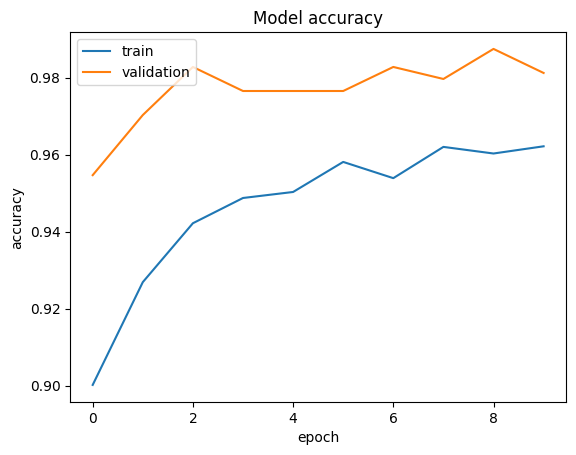

100%|██████████| 80/80 [00:03<00:00, 23.85it/s]


Epoch 1/10
400/400 [==============================] - 78s 195ms/step - loss: 0.0740 - accuracy: 0.9044 - val_loss: 0.0482 - val_accuracy: 0.9344
Epoch 2/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0599 - accuracy: 0.9209 - val_loss: 0.0384 - val_accuracy: 0.9500
Epoch 3/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0511 - accuracy: 0.9322 - val_loss: 0.0332 - val_accuracy: 0.9578
Epoch 4/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0474 - accuracy: 0.9378 - val_loss: 0.0297 - val_accuracy: 0.9594
Epoch 5/10
400/400 [==============================] - 77s 192ms/step - loss: 0.0378 - accuracy: 0.9502 - val_loss: 0.0254 - val_accuracy: 0.9656
Epoch 6/10
400/400 [==============================] - 77s 192ms/step - loss: 0.0364 - accuracy: 0.9516 - val_loss: 0.0218 - val_accuracy: 0.9703
Epoch 7/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0328 - accuracy: 0.9577 - val_loss: 0.0202 - val_ac

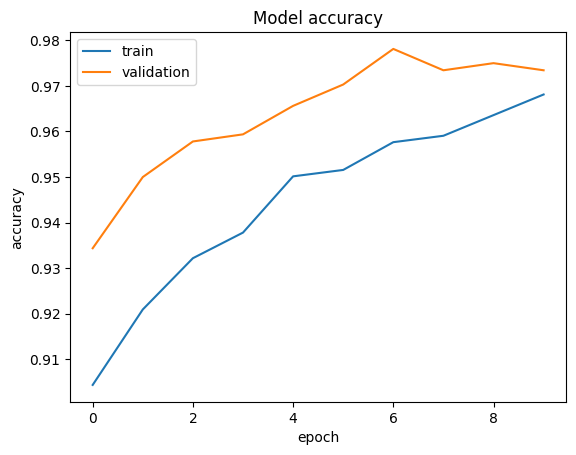

100%|██████████| 80/80 [00:03<00:00, 23.43it/s]


Epoch 1/10
400/400 [==============================] - 78s 195ms/step - loss: 0.0763 - accuracy: 0.8994 - val_loss: 0.0465 - val_accuracy: 0.9406
Epoch 2/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0553 - accuracy: 0.9275 - val_loss: 0.0361 - val_accuracy: 0.9516
Epoch 3/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0517 - accuracy: 0.9317 - val_loss: 0.0320 - val_accuracy: 0.9578
Epoch 4/10
400/400 [==============================] - 77s 193ms/step - loss: 0.0433 - accuracy: 0.9447 - val_loss: 0.0270 - val_accuracy: 0.9641
Epoch 5/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0390 - accuracy: 0.9477 - val_loss: 0.0250 - val_accuracy: 0.9656
Epoch 6/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0355 - accuracy: 0.9541 - val_loss: 0.0230 - val_accuracy: 0.9719
Epoch 7/10
400/400 [==============================] - 78s 194ms/step - loss: 0.0330 - accuracy: 0.9556 - val_loss: 0.0218 - val_ac

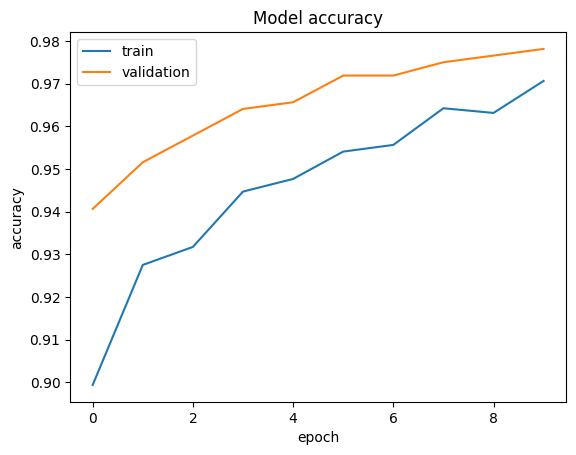

 80%|████████  | 64/80 [00:27<00:06,  2.33it/s]


KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
from datasets import load_dataset

ds_family = 'arieg/bw_spec_cls_80'

for batch_num in range(0, 43):

    # load dataset
    ds_train = load_dataset( f"{ds_family}_{batch_num:02d}", split='train', keep_in_memory=True)
    ds_train.set_format('tf')

    # make pairs
    pairs_train, labels_train = make_pairs( ds_train, 40)
    pairs_val, labels_val = make_pairs( ds_train, 4)

    x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
    x_train_2 = pairs_train[:, 1]
    del pairs_train

    x_val_1 = pairs_val[:, 0]
    x_val_2 = pairs_val[:, 1]
    del pairs_val

    # train
    history = siamese.fit(
        [x_train_1, x_train_2],
        labels_train,
        validation_data=([x_val_1, x_val_2], labels_val),
        batch_size=batch_size,
        epochs=epochs,
    )

    # save model
    folder = '/content/drive/MyDrive/Colab Notebooks/Zama'
    siamese.save(folder + '/siamese_model.h5')
    embedding_network.save(folder + '/embedding_network.h5')

    # plot
    plt_metric(history=history.history, metric="accuracy", title="Model accuracy", savefig=f'{folder}/accuracy_{batch_num:02d}.png')


## Train the model

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

In [ ]:
folder = '/content/drive/MyDrive/Colab Notebooks/Zama'
siamese.save(folder + '/siamese_model.h5')
embedding_network.save(folder + '/embedding_network.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualize results

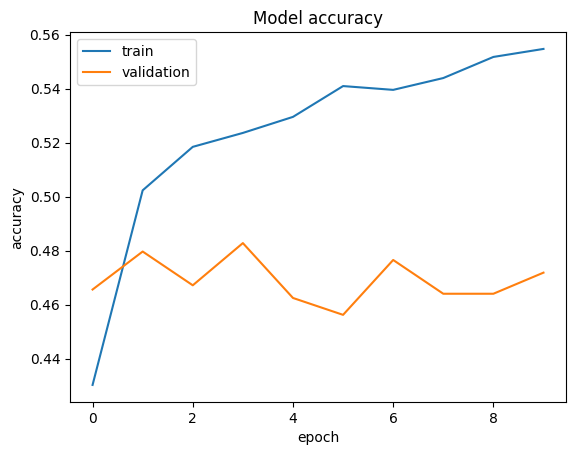

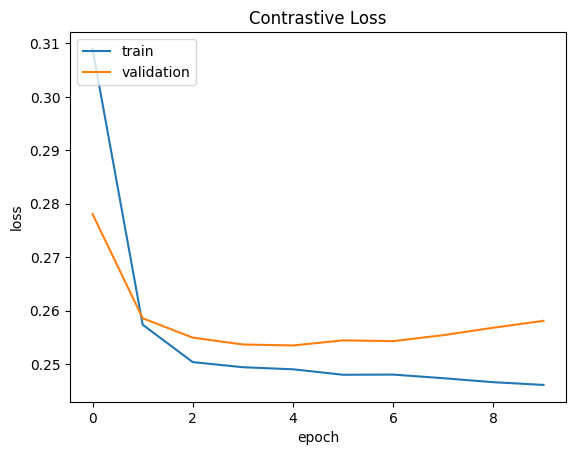

In [ ]:

def plt_metric(history, metric, title, has_valid=True, savefig=None):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

    if savefig:
        plt.savefig(savefig)

# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

## Evaluate the model

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)